In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import commons
import textwrap
import math
import os

In [2]:
# load data and ratings about open-source projects

features = set()
scores = set()
data = []
score_weights = {}

def process_used_score_value(used_value, row, score_weights):
    score_type = used_value['score']['type']
    if used_value['isNotApplicable']:
        row[score_type] = 'N/A'
    else:
        row[score_type] = used_value['value']
    if score_type not in score_weights:
        score_weights[score_type] = used_value['weight']
    elif score_weights[score_type] != used_value['weight']:
        raise Exception('Oops! Weights do not match!')

def process_vulnerability_value(used_value, row):
    row['# of vulnerabilities'] = len(used_value['vulnerabilities']['entries'])
    row['# of unpatched vulnerabilities'] = 0
    row['# of patched vulnerabilities'] = 0
    row['# of vulnerabilities without introduced date'] = 0
    row['# of vulnerabilities without fixed date'] = 0
    for entry in used_value['vulnerabilities']['entries']:
        if entry['resolution'] == 'UNPATCHED':
            row['# of unpatched vulnerabilities'] = row['# of unpatched vulnerabilities'] + 1
        elif entry['resolution'] == 'PATCHED':
            row['# of patched vulnerabilities'] = row['# of patched vulnerabilities'] + 1
        if entry['introduced'] is None:
            row['# of vulnerabilities without introduced date'] = row['# of vulnerabilities without introduced date'] + 1
        if entry['fixed'] is None:
            row['# of vulnerabilities without fixed date'] = row['# of vulnerabilities without fixed date'] + 1
        
def process_sub_scores(score_value, row, score_weights):
    for used_value in score_value['usedValues']:
        if used_value['type'] == 'ScoreValue':
            scores.add(used_value['score']['type'])
            process_used_score_value(used_value, row, score_weights)
            process_sub_scores(used_value, row, score_weights)
            continue
        
        feature = used_value['feature']['name']
        features.add(feature)
          
        if used_value['type'] == 'UnknownValue':
            row[feature] = 'unknown'
        elif used_value['type'] == 'VulnerabilitiesValue':
            process_vulnerability_value(used_value, row)
                
        elif used_value['type'] == 'IntegerValue':
            row[feature] = used_value['number']
        elif used_value['type'] == 'BooleanValue':
            row[feature] = used_value['flag']
        elif used_value['type'] == 'DateValue':
            row[feature] = used_value['date']
        elif used_value['type'] == 'LanguagesValue':
            row[feature] = used_value['languages']['elements']
        elif used_value['type'] == 'PackageManagersValue':
            row[feature] = used_value['packageManagers']['packageManagers']
        elif used_value['type'] == 'LgtmGradeValue':
            row[feature] = used_value['value']
        elif used_value['type'] == 'OwaspDependencyCheckUsageValue':
            row[feature] = used_value['value']
        elif used_value['type'] == 'SecurityReviewsValue':
            row[feature] = used_value['reviews']
        elif used_value['type'] == 'OwaspDependencyCheckCvssThresholdValue':
            # we convert the numbers to string because it's necessary
            # to draw the charts below
            row[feature] = str(used_value['number'])
        else:
            raise Exception('Unknown value type: ' + used_value['type'])
    
input_file = os.environ.get('INPUT_FILE', '../../../../../docs/oss/security/github_projects.json')
            
with open(input_file) as json_file:
    json_data = json.load(json_file)
    for json_project_data in json_data:
        row = {}
        #print(json_project_data)
        row['URL'] = 'https://github.com/' + json_project_data['organization']['name'] + '/' + json_project_data['name']
        rating_value = json_project_data['ratingValue']
        if rating_value is None:
            continue
            
        row['Label'] = rating_value['label'][1]
        
        score_value = json_project_data['ratingValue']['scoreValue']
        row['Score'] = score_value['value']
        row['Confidence'] = score_value['confidence']
        
        process_sub_scores(score_value, row, score_weights)
        
        data.append(row)
            
        
project_data = pd.DataFrame(data)
project_data.fillna('unknown', inplace = True)
project_data

,# of patched vulnerabilities,# of unpatched vulnerabilities,# of vulnerabilities,# of vulnerabilities without fixed date,# of vulnerabilities without introduced date,A CVSS threshold for OWASP Dependency Check to fail the build,A set of package managers,A set of programming languages,CodeqlScore,CommunityCommitmentScore,...,ProjectSecurityAwarenessScore,ProjectSecurityTestingScore,Score,Security reviews for a project,SecurityReviewScore,StaticAnalysisScore,The worst LGTM grade of a project,URL,UnpatchedVulnerabilitiesScore,VulnerabilityDiscoveryAndSecurityTestingScore
0,0,0,0,0,0,0.0,"[NPM, YARN]","[PYTHON, JAVASCRIPT, OTHER]",0.0,8.0,...,0.5,3.863636,5.215667,[],0.000000,2.5,C,https://github.com/GoogleChrome/lighthouse,10.0,2.0
1,0,0,0,0,0,0.0,[],"[GO, OTHER]",10.0,0.0,...,4.0,6.818182,5.535854,"[{'date': 1517616000000, 'changes': 0.96483516...",0.351648,5.0,unknown,https://github.com/coredns/coredns,10.0,2.0
2,74,0,74,74,74,0.0,[],"[C, CPP, PYTHON, OTHER]",0.0,0.0,...,7.0,4.531250,5.496011,[],0.000000,4.5,A,https://github.com/curl/curl,10.0,0.0
3,34,0,34,34,34,0.0,[],"[C, CPP, PYTHON, GO, OTHER]",0.0,0.0,...,4.5,5.833333,5.295165,"[{'date': 1517443200000, 'changes': 0.99802977...",0.019702,4.5,A,https://github.com/envoyproxy/envoy,10.0,0.0
4,9,0,9,9,9,0.0,[],"[C, CPP, C_SHARP, OTHER]",0.0,0.0,...,1.0,4.531250,3.133123,"[{'date': 1475193600000, 'changes': 0.33953488...",6.604651,4.5,A,https://github.com/madler/zlib,10.0,2.0
5,12,0,12,12,12,0.0,[MAVEN],"[C, JAVA, JAVASCRIPT, OTHER]",10.0,8.0,...,4.0,4.761905,5.821682,[],0.000000,8.0,A+,https://github.com/netty/netty,10.0,0.0
6,0,0,0,0,0,0.0,[MAVEN],"[C, JAVA, RUBY, OTHER]",10.0,8.0,...,1.0,3.333333,3.286983,[],0.000000,4.0,unknown,https://github.com/netty/netty-tcnative,10.0,2.0
7,222,0,222,222,222,0.0,[],"[C, CPP, RUBY, PYTHON, OTHER]",0.0,0.0,...,5.0,4.218750,5.334798,"[{'date': 1547856000000, 'changes': 0.32259916...",6.774008,3.5,B,https://github.com/openssl/openssl,10.0,0.0
8,1,0,1,1,1,0.0,[MAVEN],"[JAVA, JAVASCRIPT, OTHER]",0.0,0.0,...,0.5,3.636364,3.291640,[],0.000000,2.0,C,https://github.com/qos-ch/slf4j,10.0,2.0


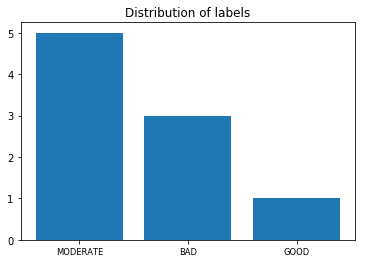

In [3]:
df = project_data['Label'].value_counts()
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.title('Distribution of labels')
plt.show()

<Figure size 720x720 with 0 Axes>

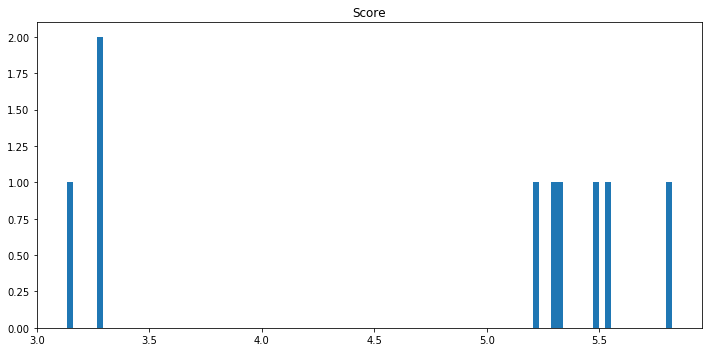

In [4]:
df = project_data
plt.figure(figsize=[10, 10])
f, ax = plt.subplots(1, 1)
f.set_figwidth(10)
f.set_figheight(5)
column = 'Score'
d = df[column]
ax.hist(d, histtype='bar', bins=100)
ax.set_title(column)
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

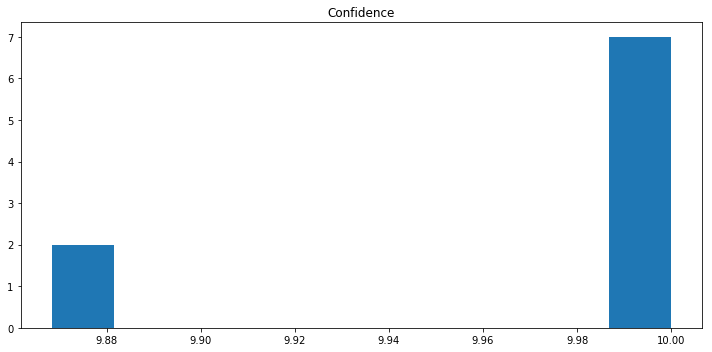

In [5]:
df = project_data
plt.figure(figsize=[10, 10])
f, ax = plt.subplots(1, 1)
f.set_figwidth(10)
f.set_figheight(5)
column = 'Confidence'
d = df[column]
ax.hist(d, histtype='bar', bins=10)
ax.set_title(column)
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

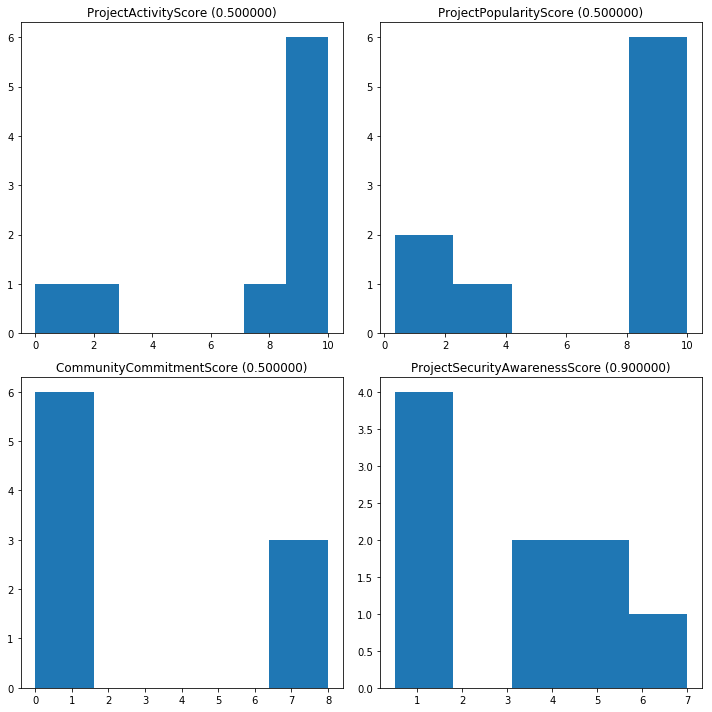

In [6]:
df = project_data[['ProjectActivityScore', 'ProjectPopularityScore', 
                   'CommunityCommitmentScore', 'ProjectSecurityAwarenessScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(10)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    column = df.columns[idx]
    d = df[column]
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

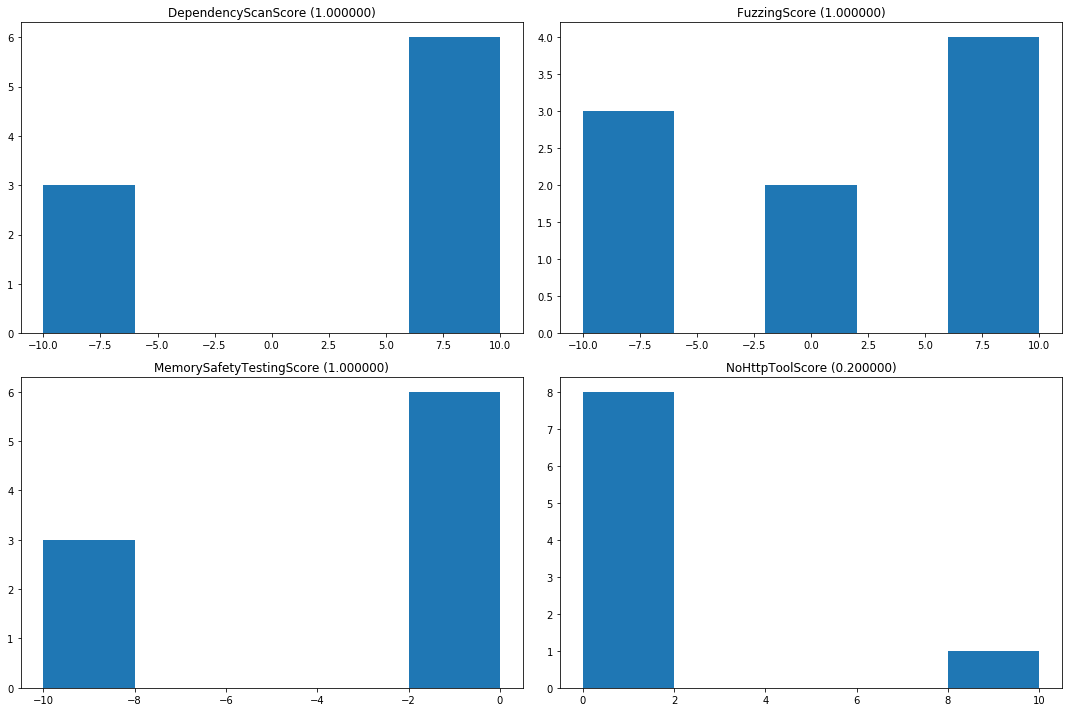

In [7]:
df = project_data[['DependencyScanScore', 'FuzzingScore', 
                   'MemorySafetyTestingScore', 'NoHttpToolScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(15)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    column = df.columns[idx]
    d = df[column]
    d = d.replace('N/A', -10)
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

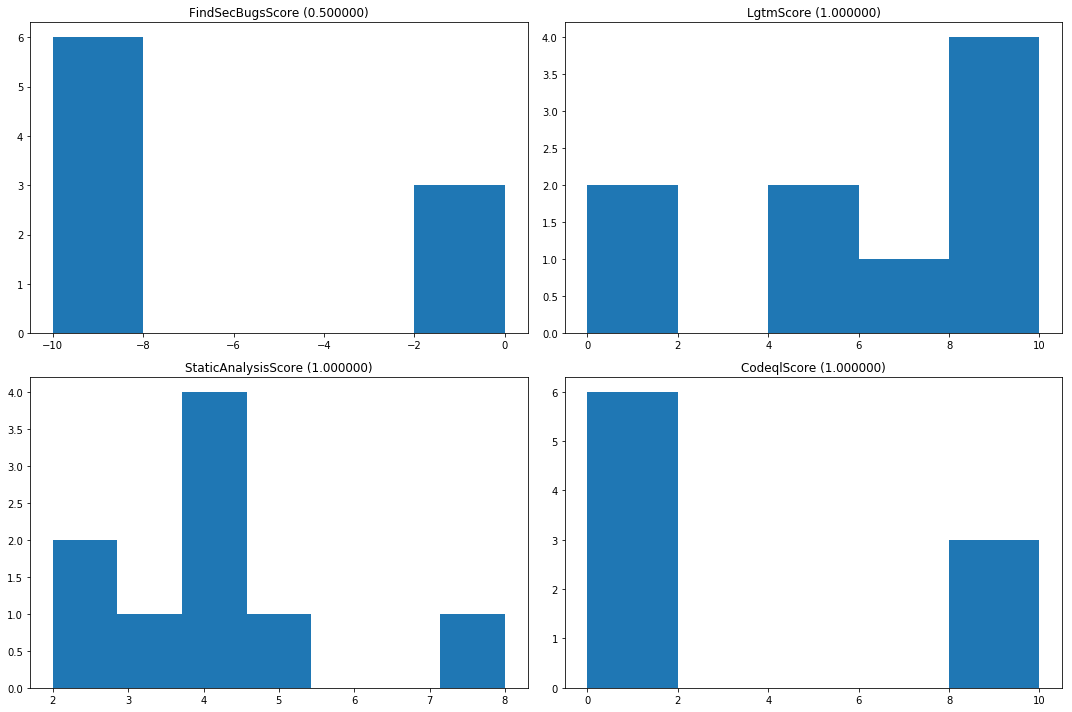

In [8]:
df = project_data[['FindSecBugsScore', 'LgtmScore', 'StaticAnalysisScore', 'CodeqlScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(15)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    if idx == len(df.columns): break
    column = df.columns[idx]
    d = df[column]
    d = d.replace('N/A', -10)
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

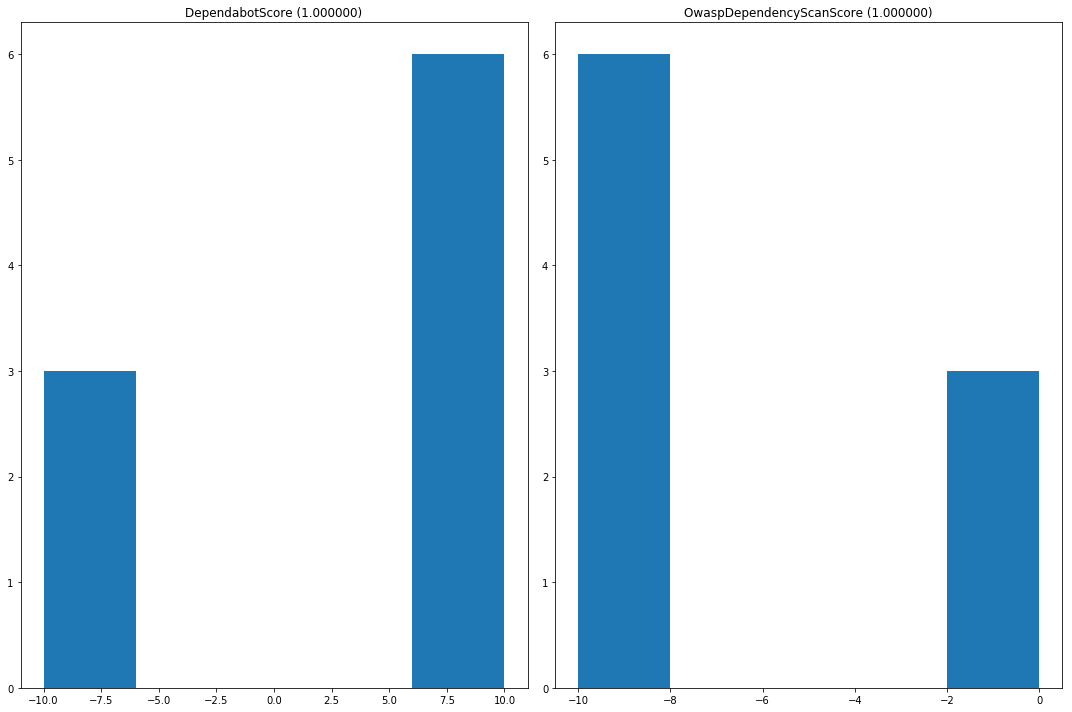

In [9]:
df = project_data[['DependabotScore', 'OwaspDependencyScanScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(1, 2)
f.set_figwidth(15)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    if idx == len(df.columns): break
    column = df.columns[idx]
    d = df[column]
    d = d.replace('N/A', -10)
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

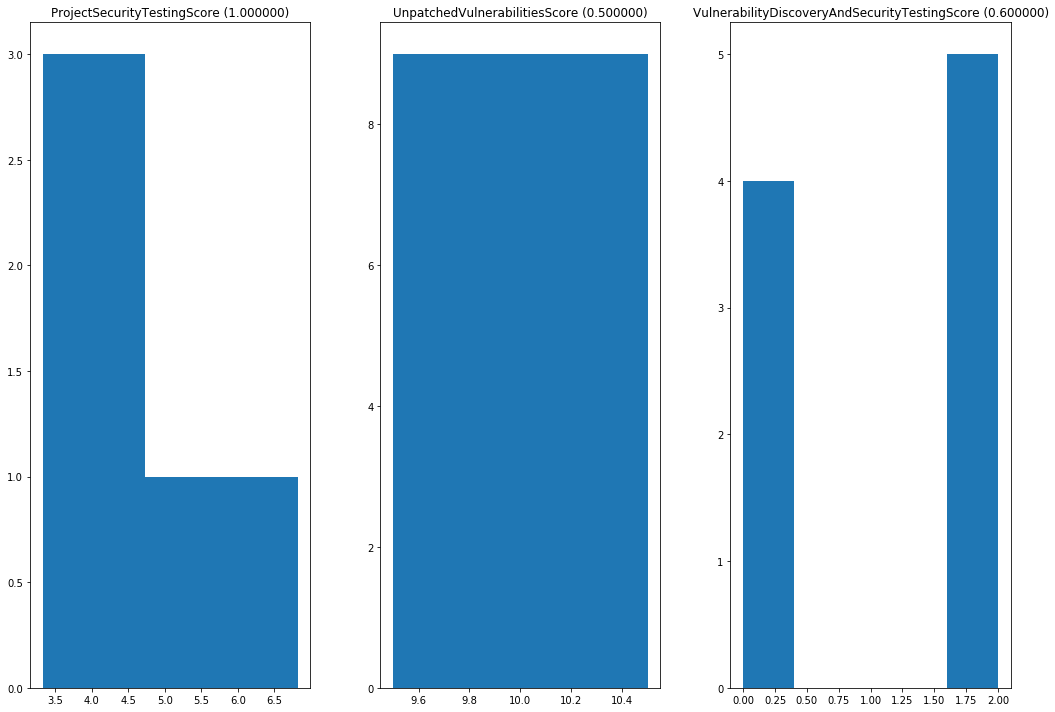

In [10]:
df = project_data[['ProjectSecurityTestingScore', 'UnpatchedVulnerabilitiesScore', 
                   'VulnerabilityDiscoveryAndSecurityTestingScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(1, 3)
f.set_figwidth(15)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    if idx == len(df.columns): break
    column = df.columns[idx]
    d = df[column]
    d = d.replace('N/A', -10)
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

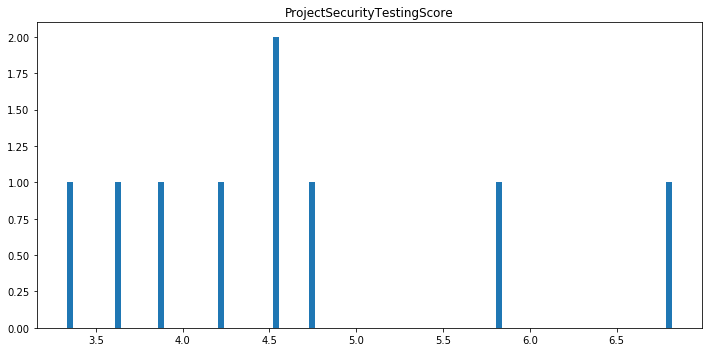

In [11]:
df = project_data
plt.figure(figsize=[10, 10])
f, ax = plt.subplots(1, 1)
f.set_figwidth(10)
f.set_figheight(5)
column = 'ProjectSecurityTestingScore'
d = df[column]
ax.hist(d, histtype='bar', bins=100)
ax.set_title(column)
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

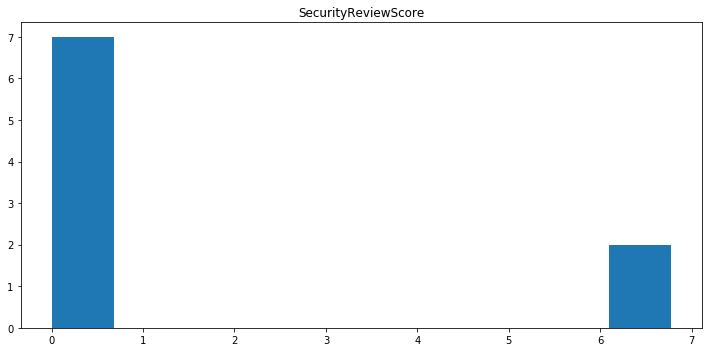

In [12]:
df = project_data
plt.figure(figsize=[10, 10])
f, ax = plt.subplots(1, 1)
f.set_figwidth(10)
f.set_figheight(5)
column = 'SecurityReviewScore'
d = df[column]
ax.hist(d, histtype='bar', bins=10)
ax.set_title(column)
plt.tight_layout()

In [13]:
pd.DataFrame.from_dict(score_weights, orient='index')

,0
ProjectSecurityAwarenessScore,0.9
UnpatchedVulnerabilitiesScore,0.5
CommunityCommitmentScore,0.5
ProjectActivityScore,0.5
ProjectSecurityTestingScore,1.0
DependencyScanScore,1.0
DependabotScore,1.0
OwaspDependencyScanScore,1.0
NoHttpToolScore,0.2
FuzzingScore,1.0


In [14]:
project_data[
    ['URL', 
     '# of vulnerabilities', 
     '# of unpatched vulnerabilities', 
     '# of patched vulnerabilities']
][project_data['# of vulnerabilities'] > 3].sort_values(by = '# of vulnerabilities', ascending=False)

,URL,# of vulnerabilities,# of unpatched vulnerabilities,# of patched vulnerabilities
7,https://github.com/openssl/openssl,222,0,222
2,https://github.com/curl/curl,74,0,74
3,https://github.com/envoyproxy/envoy,34,0,34
5,https://github.com/netty/netty,12,0,12
4,https://github.com/madler/zlib,9,0,9


In [15]:
project_data[
    ['URL', 
     '# of vulnerabilities', 
     '# of vulnerabilities without introduced date', 
     '# of vulnerabilities without fixed date']
][project_data['# of vulnerabilities'] > 3].sort_values(by = '# of vulnerabilities', ascending=False)

,URL,# of vulnerabilities,# of vulnerabilities without introduced date,# of vulnerabilities without fixed date
7,https://github.com/openssl/openssl,222,222,222
2,https://github.com/curl/curl,74,74,74
3,https://github.com/envoyproxy/envoy,34,34,34
5,https://github.com/netty/netty,12,12,12
4,https://github.com/madler/zlib,9,9,9


In [16]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def draw_boolean_hists(df, columns, a):
    a = a.ravel()
    for idx, ax in enumerate(a):
        if idx == len(df.columns): break
        column = df.columns[idx]
        if column not in columns: continue
        vc = df[column].replace(True, 'Yes').replace(False, 'No').value_counts().to_dict()
        if 'Yes' not in vc: vc['Yes'] = 0
        if 'No' not in vc: vc['No'] = 0
        if 'unknown' not in vc: vc['unknown'] = 0
        rects = ax.bar(vc.keys(), vc.values(), width=0.5)
        autolabel(rects)
        ax.set_title(column)

<Figure size 720x720 with 0 Axes>

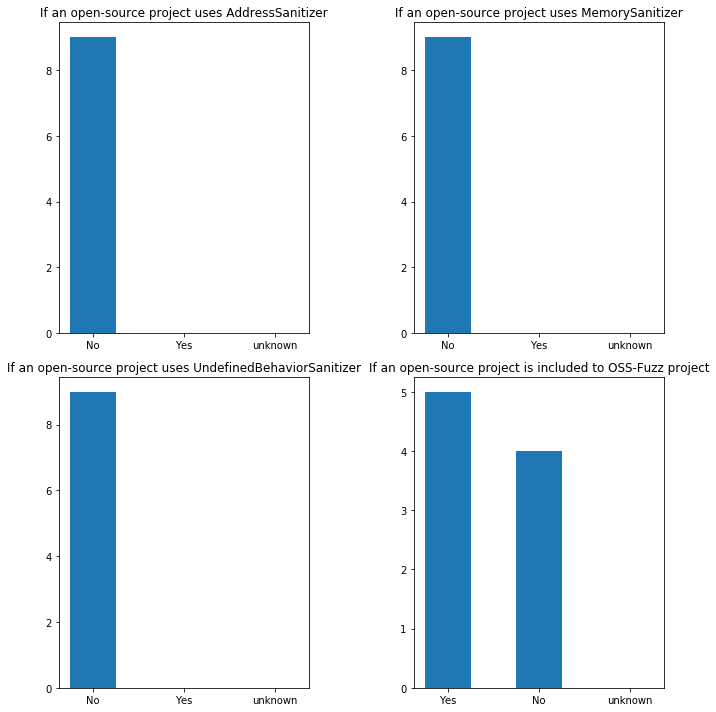

In [17]:
columns = [
    'If an open-source project uses AddressSanitizer', 
    'If an open-source project uses MemorySanitizer',
    'If an open-source project uses UndefinedBehaviorSanitizer',
    'If an open-source project is included to OSS-Fuzz project',
]

df = project_data[columns]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(10)
f.set_figheight(10)
draw_boolean_hists(df, columns, a)
f.tight_layout()

<Figure size 720x720 with 0 Axes>

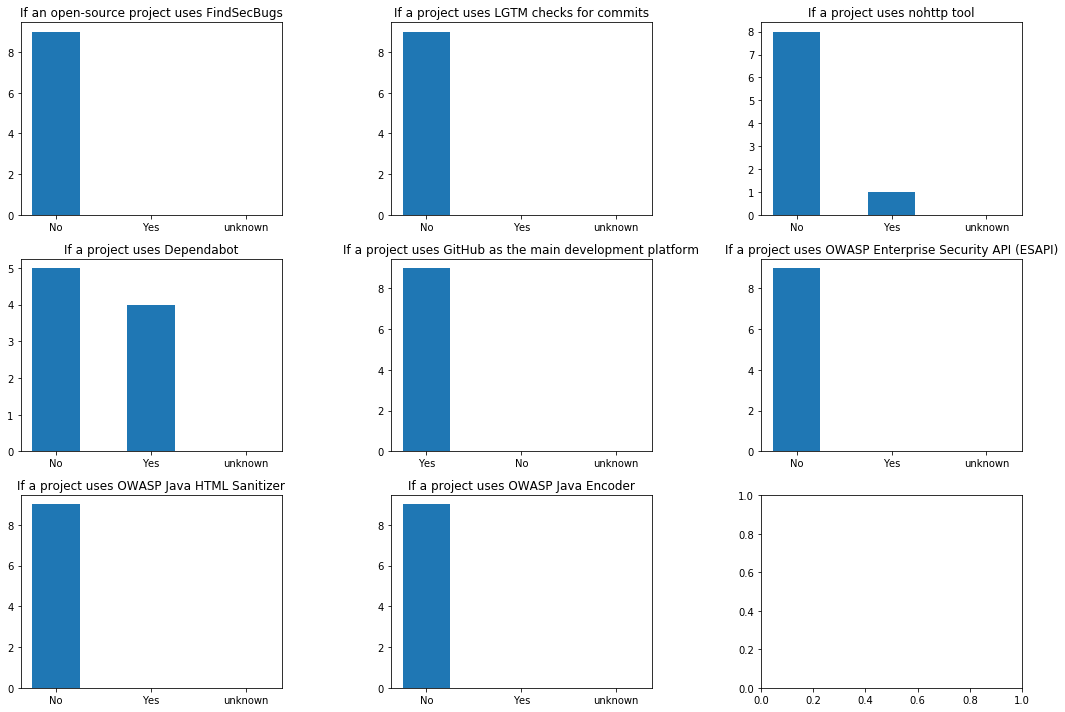

In [18]:
columns = [    
    'If an open-source project uses FindSecBugs',
    'If a project uses LGTM checks for commits',
    'If a project uses nohttp tool',
    'If a project uses Dependabot',
    'If a project uses GitHub as the main development platform',
    'If a project uses OWASP Enterprise Security API (ESAPI)',
    'If a project uses OWASP Java HTML Sanitizer',
    'If a project uses OWASP Java Encoder'
]
df = project_data[columns]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(3, 3)
f.set_figwidth(15)
f.set_figheight(10)
draw_boolean_hists(df, columns, a)
f.tight_layout()

<Figure size 720x720 with 0 Axes>

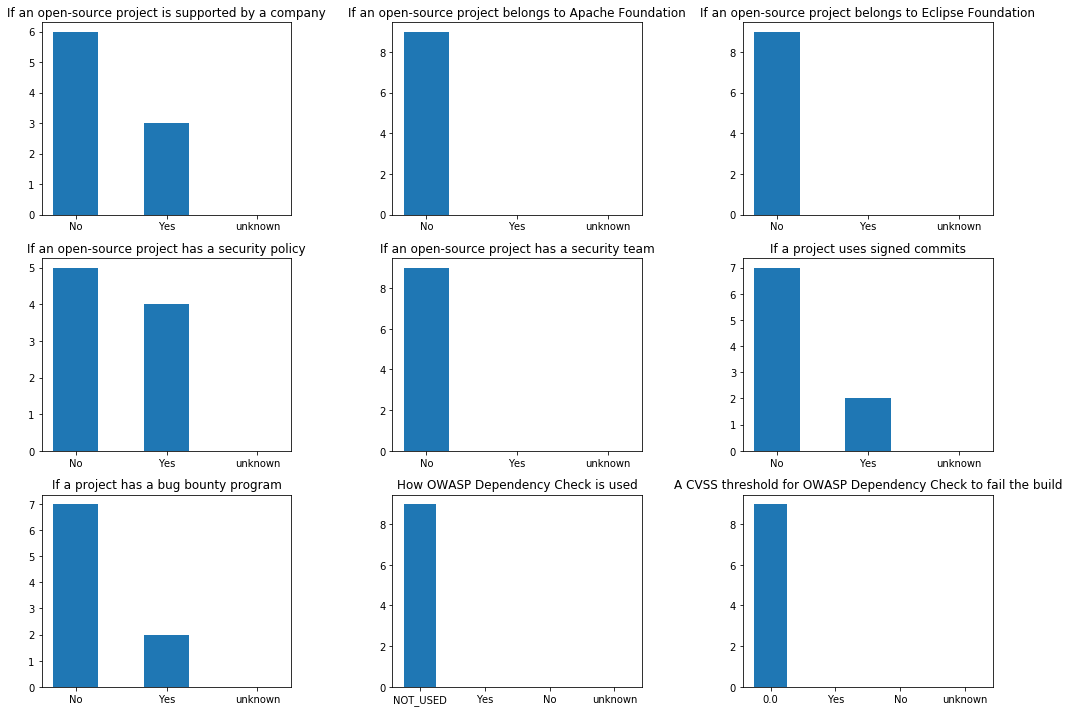

In [19]:
columns = [        
    'If an open-source project is supported by a company',
    'If an open-source project belongs to Apache Foundation',
    'If an open-source project belongs to Eclipse Foundation',
    'If an open-source project has a security policy',
    'If an open-source project has a security team',
    'If a project uses signed commits',
    'If a project has a bug bounty program',
    'How OWASP Dependency Check is used',
    'A CVSS threshold for OWASP Dependency Check to fail the build'
]

df = project_data[columns]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(3, 3)
f.set_figwidth(15)
f.set_figheight(10)
draw_boolean_hists(df, columns, a)
f.tight_layout()

In [20]:
unclear_threshold = 8.0

# target ratio for bad/moderate/good ratings
bad_ratings_fraction = 0.30
moderate_ratings_fraction = 0.50
good_ratings_fraction = 0.20

if bad_ratings_fraction + moderate_ratings_fraction + good_ratings_fraction != 1:
    raise Exception('Oops! Target ratio doesn not look correct!')

n = len(project_data.index)
target_bad_ratings_number = (int) (bad_ratings_fraction * n)
target_moderate_ratings_number = (int) (moderate_ratings_fraction * n)
target_good_ratings_number = n - target_bad_ratings_number - target_moderate_ratings_number

print('Total number of projects                           = {:d}'.format(n))
print('Target number of projects with bad ragings         = {:d}'.format(target_bad_ratings_number))
print('Target number of projects with moderate ragings    = {:d}'.format(target_moderate_ratings_number))
print('Target number of projects with good ratings        = {:d}'.format(target_good_ratings_number))
    
moderate_threshold = 0
good_threshold = 0
i = 0
for index, value in project_data['Score'].sort_values().items():
    if moderate_threshold == 0 and i >= target_bad_ratings_number:
        moderate_threshold = value
        i = 0
    if good_threshold == 0 and i >= target_moderate_ratings_number:
        good_threshold = value
        break
    i = i + 1

bad_rating_number = 0
moderate_rating_number = 0
good_rating_number = 0
total = 0
for index, value in project_data['Score'].sort_values().items():
    total = total + 1
    if value > good_threshold:
        good_rating_number = good_rating_number + 1
    elif value > moderate_threshold:
        moderate_rating_number = moderate_rating_number + 1
    else:
        bad_rating_number = bad_rating_number + 1
        
actual_bad_ratings_fraction = bad_rating_number / n
actual_moderate_ratings_fraction = moderate_rating_number / n
actual_good_ratings_fraction = good_rating_number / n
        
print('New threshold for MODERATE        = {:f}'.format(moderate_threshold))
print('New threshold for GOOD            = {:f}'.format(good_threshold))
print('Expected bad rating fraction      = {:f}'.format(bad_ratings_fraction))
print('Actual bad rating fraction        = {:f}'.format(actual_bad_ratings_fraction))
print('Expected moderate rating fraction = {:f}'.format(moderate_ratings_fraction))
print('Actual moderate rating fraction   = {:f}'.format(actual_moderate_ratings_fraction))
print('Expected good rating fraction     = {:f}'.format(good_ratings_fraction))
print('Actual good rating fraction       = {:f}'.format(actual_good_ratings_fraction))

if abs(actual_good_ratings_fraction - good_ratings_fraction) > 0.01:
    print('Achtung! We did not achieve the target fraction for GOOD ratings!')
if abs(actual_moderate_ratings_fraction - moderate_ratings_fraction) > 0.01:
    print('Achtung! We did not achieve the target fraction for MODERATE ratings!')
if abs(actual_bad_ratings_fraction - bad_ratings_fraction) > 0.01:
    print('Achtung! We did not achieve the target fraction for BAD ratings!')

Total number of projects                           = 9
Target number of projects with bad ragings         = 2
Target number of projects with moderate ragings    = 4
Target number of projects with good ratings        = 3
New threshold for MODERATE        = 3.291640
New threshold for GOOD            = 5.496011
Expected bad rating fraction      = 0.300000
Actual bad rating fraction        = 0.333333
Expected moderate rating fraction = 0.500000
Actual moderate rating fraction   = 0.444444
Expected good rating fraction     = 0.200000
Actual good rating fraction       = 0.222222
Achtung! We did not achieve the target fraction for GOOD ratings!
Achtung! We did not achieve the target fraction for MODERATE ratings!
Achtung! We did not achieve the target fraction for BAD ratings!


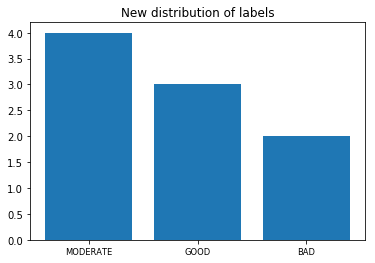

In [21]:
def get_new_label(row):
    s = row['Score']
    c = row['Confidence']
    if c < unclear_threshold: return 'UNCLEAR'
    if s >= good_threshold: return 'GOOD'
    if s >= moderate_threshold: return 'MODERATE'
    return 'BAD'

project_data['Label'] = project_data.apply(lambda row: get_new_label(row), axis=1)
df = project_data['Label'].value_counts()
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.title('New distribution of labels')
plt.show()

In [22]:
# save the new thresholds
data = {}
data['moderate'] = moderate_threshold
data['good'] = good_threshold
data['unclear'] = unclear_threshold
output_file = os.environ.get('OUTPUT_FILE', '../../../../../src/main/resources/com/sap/oss/phosphor/fosstars/model/rating/oss/OssSecurityRatingThresholds.json')
with open(output_file, 'w') as file:
    json.dump(data, file, sort_keys=True, indent=2)